## Making videos in Nocturne

This notebook shows how to get started with rendering scenarios in Nocturne.

In [7]:
# Dependencies
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import HTML, Image
import warnings
from nocturne.envs.base_env import BaseEnv
from pathlib import Path
from pyvirtualdisplay import Display
import pickle
import imageio
import pandas as pd
import seaborn as sns
import logging
import matplotlib.pyplot as plt
import torch
from utils.config import load_config_nb
from utils.sb3.reg_ppo import RegularizedPPO
from utils.policies import load_policy

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (8, 3)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')

In [8]:
# Trained policies
# model_config = load_config_nb('models_main_paper')

# Environment settings
env_config = load_config_nb('env_config')
env_config.data_path = '/Users/eugenevinitsky/Desktop/Code/github_clones/nocturne_lab/data/daphne_train_scenes/'

# Single or multi-agent
env_config.max_num_vehicles = 20
env_config.num_files = 200

# Videos
VIDEO_PATH = f'../evaluation/videos/intersecting_paths'
TRAJ_PATH = f'../evaluation/figures/trajectories'

# IL policy
human_policy = load_policy(
    data_path=f'../best_models',
    file_name=f'human_policy_D651_S500_02_18_20_05_AV_ONLY',
)


# RL policies

ppo_policy = RegularizedPPO.load(
    f'../best_models/policy_ppo_S200_I3000.zip'
)

hr_ppo_policy = RegularizedPPO.load(
    f'../best_models/policy_L0.06_S200_I3366.zip'
)



INFO:root:No regularization weight specified, using default PPO.
INFO:root:No regularization weight specified, using default PPO.


### Helper functions

In [9]:
def create_video(image_array, filename, *, fps=4, loop=500):
    with imageio.get_writer(filename, duration=1_000 / fps, loop=loop) as writer:
        for img in image_array:
            img = np.moveaxis(img, [0, 1, 2], [2, 0, 1])
            writer.append_data(img)


def display_gif(filename, width=500, height=500):
    display(
        Image(
            data=open(filename, "rb").read(), format="gif", width=width, height=height
        )
    )

### Configurations

In [10]:
# Set the path to where you want to save the videos
VIDEO_PATH = '../evaluation/videos'

# # Load the environment configuration
# env_config = load_config_nb("env_config")
# # Because we're in a notebook, we need to change the path to the data
# env_config.data_path = f"../{env_config.data_path}"

# How slow/fast the video should be
FPS = 4

### Rendering Options in Python

To render the environment, you can use the following functions:

- `env.scenario.getImage()`: Displays the main scenario image.
- `env.scenario.getConeImage()`: Shows the overlay image with cones.
- `env.scenario.getFeaturesImage()`: Provides an overlay image highlighting features.

First, make sure ensure to reset the environment to a random new scenario or a specific filename:

```python
env.reset(filename='your-scenario')
```

In [11]:
# Make environment
env = BaseEnv(env_config)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/eugenevinitsky/Desktop/Code/github_clones/nocturne_lab/data/daphne_train_scenes/valid_files.json'

In [30]:
# Make some videos of PPO vs. HR-PPO side by side
# Reset the environment
# some seemingly good options
# tfrecord-00087-of-01000_217.json

base_path = "/Users/eugenevinitsky/Desktop/Code/github_clones/nocturne_lab/data/daphne_train_scenes/"

obs_dict = env.reset(filename=base_path + "tfrecord-00087-of-01000_217.json")
scene_name = str(env.file)
frames = []
action_dict = {}

# configuration for tfrecord-00087-of-01000_217.json
veh_arr = [veh for veh in env.controlled_vehicles]
veh_arr.append(veh_arr[0:2])
veh_arr = veh_arr[2:]

for time_step in range(90):
    
    if time_step % 2 == 0:
        with Display(backend="xvfb") as disp:
            # Render the scene
            render_scene = env.scenario.getImage(
                img_width=1600,
                img_height=1600,
                draw_target_positions=True,
                padding=0,#-400.0,
                sources=veh_arr,
                view_width=120,
                view_height=120,
                rotate_with_source=False,
                move_with_source=True,
            )
            # Append to frames
            frames.append(render_scene.T)

    # Step
    for agent_id in obs_dict:
        # Get observation
        obs = torch.from_numpy(obs_dict[agent_id]).unsqueeze(dim=0)

        # Get action
        action, _ = hr_ppo_policy.predict(obs, deterministic=False)
        action_dict[agent_id] = int(action)
    obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
    
    if done_dict['__all__']:
        break
    
Path(f"{VIDEO_PATH}/{scene_name.split('/')[-1]}").parent.mkdir(parents=True, exist_ok=True)
create_video(frames, f"{VIDEO_PATH}/{scene_name.split('/')[-1]}.gif", fps=FPS)
display(HTML(f"<h3>{scene_name}</h3>"))
display_gif(f"{VIDEO_PATH}/{scene_name.split('/')[-1]}.gif")
print(str(env.file))


/Users/eugenevinitsky/Desktop/Code/github_clones/nocturne_lab/data/daphne_train_scenes/tfrecord-00087-of-01000_217.json


INFO:pyvirtualdisplay.abstractdisplay:Successfully started X with display ":9307".


TypeError: getImage(): incompatible function arguments. The following argument types are supported:
    1. (self: nocturne_cpp.Scenario, img_height: int = 1000, img_width: int = 1000, draw_target_positions: bool = True, padding: float = 50.0, sources: List[nocturne_cpp.Object] = [], view_height: int = 200, view_width: int = 200, rotate_with_source: bool = True, move_with_source: bool = True) -> numpy.ndarray[numpy.uint8]

Invoked with: <nocturne_cpp.Scenario object at 0x1691ca970>; kwargs: img_width=1600, img_height=1600, draw_target_positions=True, padding=0, sources=[<nocturne_cpp.Vehicle object at 0x1691f9430>, <nocturne_cpp.Vehicle object at 0x1691c9c30>, <nocturne_cpp.Vehicle object at 0x1691c8630>, <nocturne_cpp.Vehicle object at 0x1682474b0>, <nocturne_cpp.Vehicle object at 0x1691cb630>, <nocturne_cpp.Vehicle object at 0x1691cb270>, [<nocturne_cpp.Vehicle object at 0x1691c9f70>, <nocturne_cpp.Vehicle object at 0x1691cb8b0>]], view_width=120, view_height=120, rotate_with_source=False, move_with_source=True

In [52]:
# Reset the environment
obs_dict = env.reset(filename="/Users/eugenevinitsky/Desktop/Code/github_clones/nocturne_lab/data/train_no_tl/tfrecord-00000-of-01000_345.json")
scene_name = str(env.file)
frames = []
action_dict = {}

for time_step in range(90):
    
    if time_step % 2 == 0:
        with Display(backend="xvfb") as disp:
            # Render the scene
            render_scene = env.scenario.getImage(
                img_width=1600,
                img_height=1600,
                draw_target_positions=True,
                padding=50.0,
                sources=[env.controlled_vehicles[0]],
                view_width=120,
                view_height=120,
                rotate_with_source=,
            )
            # Append to frames
            frames.append(render_scene.T)

    # Step
    obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
    
    if done_dict['__all__']:
        break

SyntaxError: invalid syntax (1311103796.py, line 20)

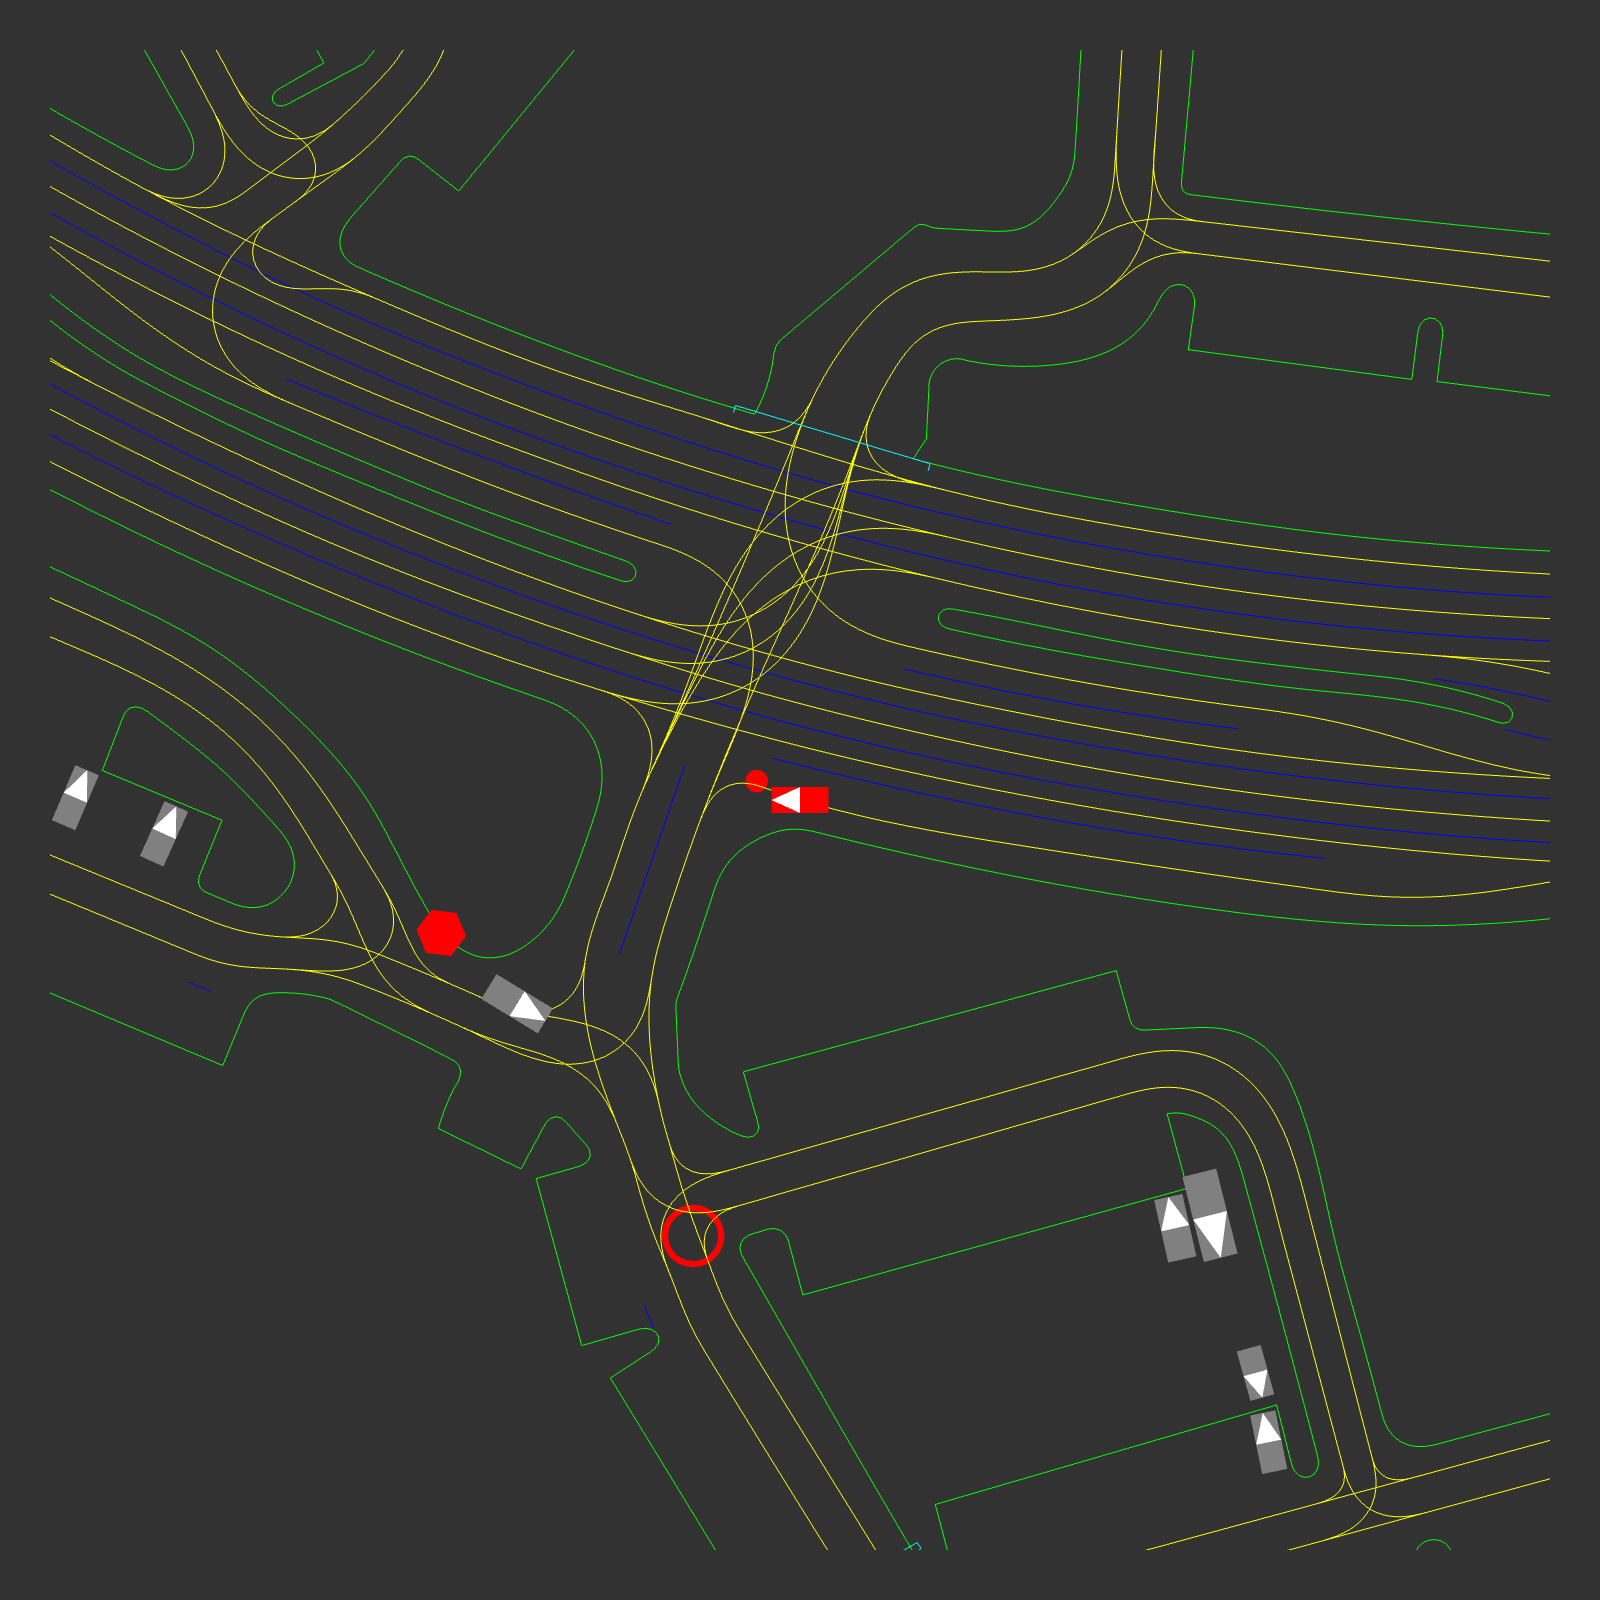

In [32]:
Path(f"{VIDEO_PATH}/{scene_name}").parent.mkdir(parents=True, exist_ok=True)
create_video(frames, f"{VIDEO_PATH}/{scene_name}.gif", fps=FPS)
display(HTML(f"<h3>{scene_name}</h3>"))
display_gif(f"{VIDEO_PATH}/{scene_name}.gif")

In [8]:
# Reset the environment
obs_dict = env.reset(filename="/Users/eugenevinitsky/Desktop/Code/github_clones/nocturne_lab/data/train_no_tl/tfrecord-00000-of-01000_345.json")
scene_name = str(env.file)
frames = []
action_dict = {}

controlled_veh = env.controlled_vehicles[0]
env.scenario.addVehicle(len(env.scenario.getVehicles()), controlled_veh.length,
                        controlled_veh.width,
                        controlled_veh.position,
                        controlled_veh.heading,
                        controlled_veh.speed,
                        controlled_veh.target_position,
                        controlled_veh.target_heading,
                        controlled_veh.target_speed,
                        True)
env.controlled_vehicles.append(env.scenario.getVehicles()[-1])

for veh in env.scenario.getVehicles():
    veh.expert_control = True
env.scenario.getVehicles()[-1].expert_control = False
print(env.scenario.getVehicles()[-1].expert_control)

for time_step in range(90):
    
    if time_step % 2 == 0:
        with Display(backend="xvfb") as disp:
            # Render the scene
            render_scene = env.scenario.getImage(
                img_width=1600,
                img_height=1600,
                draw_target_positions=True,
                padding=50.0,
                sources=[env.controlled_vehicles[0], env.scenario.getVehicles()[-1]],
                view_width=120,
                view_height=120,
                rotate_with_source=True,
            )
            # Append to frames
            frames.append(render_scene.T)

    for veh in env.scenario.getVehicles():
        action_dict[veh.id] = np.random.random(2)
    # Step
    obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
    
    if done_dict['__all__']:
        break
    
Path(f"{VIDEO_PATH}/{scene_name}").parent.mkdir(parents=True, exist_ok=True)
create_video(frames, f"{VIDEO_PATH}/{scene_name}.gif", fps=FPS)
display(HTML(f"<h3>{scene_name}</h3>"))
display_gif(f"{VIDEO_PATH}/{scene_name}.gif")

False


KeyError: 11

In [6]:
env.scenario.getVehicles()[-1] in env.controlled_vehicles

False